# Project: Evaluation of neural network architectures on MNIST datasets

## Group Members : Yidong HUANG, Simon ROBER, Marck-Edward KEMEH

### ABOUT
The MNIST dataset is a large database of handwritten digits used in many forms of image processing.
This dataset contains 60,000 training images and 10,000 test images. Our aim is to design some neural 
networks that can recognise these hand-written digits. our projects will be based on two different networks
for this task.                   

In [28]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import scikitplot as skplt
import matplotlib.pyplot as plt

We begin by splitting the MNIST dataset into two. Aset for training and another for testing.
we then normalize the test set and training set by dividing with 255 so that the values can be between 0 and 1.
Becuase we will be working with convolutional neural network, we need to change the original shape of the MNIST 
dataset which is (60000, 28, 28) to that of the convolutional neural network (60000, 28, 28, 1).
This section is just to prepare our dataset for the network.

In [29]:
# dividing dataset into train and test set, also reshaping dataset to fit input of network
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
print('shape before adding dimension is :' ,x_train.shape)
x_train, x_test = np.expand_dims(x_train, axis= -1), np.expand_dims(x_test, axis = -1)
x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)
print ('shape after adding dimension is :' ,x_train.shape)

shape before adding dimension is : (60000, 28, 28)
shape after adding dimension is : (60000, 28, 28, 1)


### First Model
Our first model is a simple network definition which will be used to train the neural network.
our input shape has to match that of the train set as did above and we are using relu as activation
~~The convolutional layers play an important role in the learning ability of the network. Having more 
layers might improve the learning of the datasets hence have a high accuracy on the test sets.~~

~~Having a single convolutional layers with 32 filters gives us a test accuracy of 0.975.~~

~~inputs = layers.Input(shape = (28,28,1))~~
~~conv = layers.Conv2D(32, (3,3), padding ='valid', activation = 'relu')(inputs)~~
~~pool = layers.MaxPool2D((2,2), (2, 2))(conv)~~
~~flat = layers.Flatten()(conv3)~~
~~outputs = layers.Dense(10, activation = 'softmax')(flat)~~
~~model = models.Model(inputs, outputs)~~
~~model.summary()~~
~~model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",~~
~~metrics = ["accuracy"])~~
                
                
~~Adding another convolutional layer with 64 number of filters increased the test accuracy to 0.984.
Adding a third layer with 124 filters and training 4 epochs increased the accuracy to 0.990~~
~~This tells us that more epochs also increases the learning accuracy
Model with 3 layers is shown below~~

In [30]:
#first simple model
''' Old Syntax:
inputs = layers.Input(shape = (28,28,1))
conv = layers.Conv2D(32, (3,3), padding ='valid', activation = 'relu')(inputs)
pool = layers.MaxPool2D((2,2), (2, 2))(conv)
flat = layers.Flatten()(conv3)
outputs = layers.Dense(10, activation = 'softmax')(flat)
model = models.Model(inputs, outputs)
model.summary()
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])
'''

model1 = keras.Sequential()
model1.add(layers.Input(shape = (28,28,1)))
model1.add(layers.Conv2D(32, (3,3), padding ='valid', activation = 'relu'))
model1.add(layers.MaxPool2D((2,2), (2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(10, activation = 'softmax'))
model1.summary()
model1.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])




Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [31]:
'''
inputs = layers.Input(shape = (28,28,1))
conv1 = layers.Conv2D(32, (3,3), padding ='valid', activation = 'relu')(inputs)
pool1 = layers.MaxPool2D((2,2), (2, 2))(conv1)
conv2 = layers.Conv2D(64, (3,3), padding ='valid', activation = 'relu')(pool1)
pool2 = layers.MaxPool2D((2,2), (2, 2))(conv2)
conv3 = layers.Conv2D(128, (3,3), padding ='valid', activation = 'relu')(pool2)

flat = layers.Flatten()(conv3)
outputs = layers.Dense(10, activation = 'softmax')(flat)

model1 = models.Model(inputs, outputs)
model1.summary()
model1.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])
'''

'\ninputs = layers.Input(shape = (28,28,1))\nconv1 = layers.Conv2D(32, (3,3), padding =\'valid\', activation = \'relu\')(inputs)\npool1 = layers.MaxPool2D((2,2), (2, 2))(conv1)\nconv2 = layers.Conv2D(64, (3,3), padding =\'valid\', activation = \'relu\')(pool1)\npool2 = layers.MaxPool2D((2,2), (2, 2))(conv2)\nconv3 = layers.Conv2D(128, (3,3), padding =\'valid\', activation = \'relu\')(pool2)\n\nflat = layers.Flatten()(conv3)\noutputs = layers.Dense(10, activation = \'softmax\')(flat)\n\nmodel1 = models.Model(inputs, outputs)\nmodel1.summary()\nmodel1.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",\n                metrics = ["accuracy"])\n'

We now test using our test set against the model we trained to determine if the model actually learnt to recognise the digits. for each epoch, we can see the loss rate is decreasing which tells us the model is actually improving on the learning.

In [32]:
#training
model1.fit(x_train, y_train, epochs = 4)

Epoch 1/4
60000/60000 [==============================] - 21s 355us/sample - loss: 0.2139 - acc: 0.9393
Epoch 2/4
60000/60000 [==============================] - 20s 333us/sample - loss: 0.0807 - acc: 0.9765
Epoch 3/4
60000/60000 [==============================] - 21s 354us/sample - loss: 0.0611 - acc: 0.9820
Epoch 4/4
60000/60000 [==============================] - 21s 349us/sample - loss: 0.0497 - acc: 0.9848


Next we use the accuracy to determine how well our classifier classifies on the test set to make sure we are not over fitting.


In [33]:
def accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print("test loss is : {0} - test accuracy is : {1}".format(test_loss, test_acc))

    
# Accuracy:
accuracy(model1, x_test, y_test)

10000/10000 [==============================] - 1s 141us/sample - loss: 0.0556 - acc: 0.9809
test loss is : 0.055637731567397715 - test accuracy is : 0.98089998960495


#### ROC
We implement the ROC curve and Precision-Recall curve to view the performance of our model on the test set

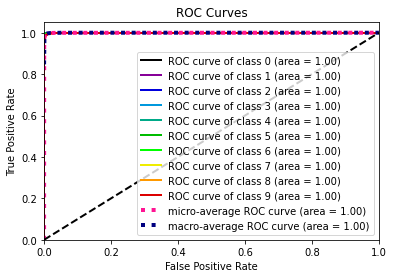

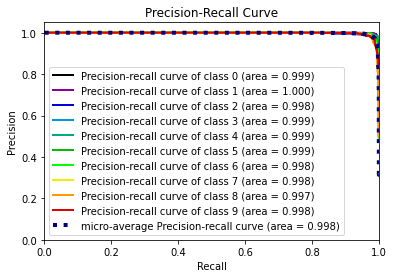

In [34]:
def roc_curve(model, x_test, y_test):
    y_true = y_test # Given ground truth
    y_probas = model.predict(x_test)
    skplt.metrics.plot_roc(y_true, y_probas)     # https://scikit-plot.readthedocs.io/en/stable/metrics.html
    plt.show()

# ROC:
roc_curve(model1, x_test, y_test)

def precision_recall(model, x_test, y_test):
    y_probas = model.predict(x_test)
    skplt.metrics.plot_precision_recall(y_test, y_probas)
    plt.show()
    
# Precision-Recall:
precision_recall(model1, x_test, y_test)

**TODO: interpret results of Roc Curve, Precision recall!!! **

#### Learning Rate

#### Batch Size

#### Number of epochs

#### Kernel size

#### New First model with optimised parameters.

### Second Model
Below is our second model which follows LeNet architecture and has an input shape of (32, 32, 1). Again we define the network, train it and see how it performs in terms of accuracy, Roc curve and Precision-Recall curve.

In [35]:
model2 = keras.Sequential()

model2.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model2.add(layers.AveragePooling2D())

model2.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model2.add(layers.AveragePooling2D())

model2.add(layers.Flatten())

model2.add(layers.Dense(units=120, activation='relu'))

model2.add(layers.Dense(units=84, activation='relu'))

model2.add(layers.Dense(units=10, activation = 'softmax'))
model2.summary()
model2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train, epochs = 4)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_2 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_11 (Dense)             (None, 84)              

As we can notice here the size of the network namely the number of parameters has decreased a lot from previous model(from 104,202 to 60,074). Thus takes less time to train.

10000/10000 [==============================] - 2s 207us/sample - loss: 0.0383 - acc: 0.9886
test loss is : 0.03834163255535532 - test accuracy is : 0.9886000156402588


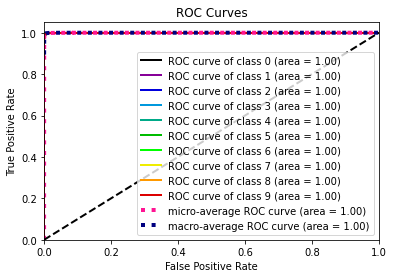

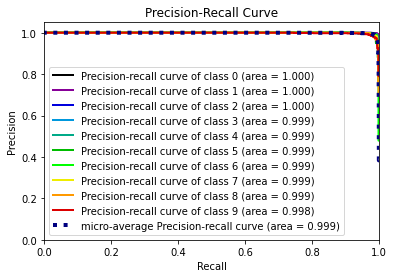

In [36]:
accuracy(model2, x_test, y_test)
roc_curve(model2, x_test, y_test)
precision_recall(model2, x_test, y_test)

But we notice that the gap between tranning accuracy and testing accuracy has increased here for the second model. We suspect that the added layer may caused slight over fitting here.*(Needs to verify.)*

**TODO: interpret results of Roc Curve, Precision recall!!! + Add comments to the model.**

As you can see we now use all the previous defined functions to build the second model.
These first two model were our first experience playing around with Keras and with the CNN. In the next section we will look into the parameters in a more systematic maner. We will build on the second model described above and alter one parameter everytime

#### Learning Rate

By default the learning rate with Adam is 0.001. Lets increase and decease i slightly to see what the effect is.

In [37]:
model2_increase_lr = keras.Sequential()

model2_increase_lr.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model3.add(layers.AveragePooling2D())

model2_increase_lr.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model2_increase_lr.add(layers.AveragePooling2D())

model2_increase_lr.add(layers.Flatten())

model2_increase_lr.add(layers.Dense(units=120, activation='relu'))

model2_increase_lr.add(layers.Dense(units=84, activation='relu'))

model2_increase_lr.add(layers.Dense(units=10, activation = 'softmax'))
model2_increase_lr.summary()
model2_increase_lr.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_increase_lr.fit(x_train, y_train, epochs = 4)

accuracy(model2_increase_lr, x_test, y_test)
roc_curve(model2_increase_lr, x_test, y_test)
precision_recall(model2_increase_lr, x_test, y_test)

NameError: name 'model3' is not defined

In [ ]:
model2_decrease_lr = keras.Sequential()

model2_decrease_lr.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model2_decrease_lr.add(layers.AveragePooling2D())

model2_decrease_lr.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model2_decrease_lr.add(layers.AveragePooling2D())

model2_decrease_lr.add(layers.Flatten())

model2_decrease_lr.add(layers.Dense(units=120, activation='relu'))

model2_decrease_lr.add(layers.Dense(units=84, activation='relu'))

model2_decrease_lr.add(layers.Dense(units=10, activation = 'softmax'))
model2_decrease_lr.summary()
model2_decrease_lr.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_decrease_lr.fit(x_train, y_train, epochs = 4)


accuracy(model2_decrease_lr, x_test, y_test)
roc_curve(model2_decrease_lr, x_test, y_test)
precision_recall(model2_decrease_lr, x_test, y_test)

We notice that both alterations decrease the accuracy. This means we have hit the sweet spot! The learning rate cannot be to large nor to small, because ....

#### Batch Size

#### Number of epochs

#### Kernel size

#### New Second model with optimised parameters.

#### Conclusion New First and New Second Model

**TODO: Describe which of the two performs the best, compare. The one that is the best can be used as a baseline for the grade 14-18 part.**